In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install yt-dlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 60.5 MB/s eta 0:00:00


In [ ]:
from yt_dlp import YoutubeDL

# Extracting 50 newest videos from Sabrina's official youtube channel
def get_top_50_video_ids(channel_url):
    ydl_opts = {
        'extract_flat': True,
        'force_generic_extractor': True,
        'quiet': True,
    }
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(channel_url, download=False)
    return [entry['id'] for entry in info['entries'][:50]]

channel_url = 'https://www.youtube.com/@sabrinacarpenter/videos'
video_ids = get_top_50_video_ids(channel_url)
print(f"Total videos fetched: {len(video_ids)}")


Total videos fetched: 50


In [ ]:
# Importing libraries
import os
import time

# Downloading comments from youtube
for vid in video_ids:
    print(f"Downloading metadata for: {vid}")
    !yt-dlp --skip-download --write-info-json --write-comments --extractor-args "youtube:player_client=web" --output "%(title)s.%(id)s.%(ext)s" https://www.youtube.com/watch?v={vid}
    time.sleep(2)  # polite pause to avoid IP throttle


Streaming output truncated to the last 5000 lines.
[youtube]     Downloading comment API JSON reply thread 1 (130/~1222)
[youtube] Downloading comment API JSON page 7 (149/~1222)
[youtube]     Downloading comment API JSON reply thread 1 (152/~1222)
[youtube]     Downloading comment API JSON reply thread 2 (162/~1222)
[youtube] Downloading comment API JSON page 8 (171/~1222)
[youtube]     Downloading comment API JSON reply thread 1 (177/~1222)
[youtube] Downloading comment API JSON page 9 (192/~1222)
[youtube]     Downloading comment API JSON reply thread 1 (203/~1222)
[youtube] Downloading comment API JSON page 10 (213/~1222)
[youtube]     Downloading comment API JSON reply thread 1 (215/~1222)
[youtube]     Downloading comment API JSON reply thread 2 (220/~1222)
[youtube]     Downloading comment API JSON reply thread 3 (224/~1222)
[youtube]     Downloading comment API JSON reply thread 4 (228/~1222)
[youtube] Downloading comment API JSON page 11 (238/~1222)
[youtube]     Downloading c

In [ ]:
import json
from datetime import datetime
from collections import defaultdict

# Initialize a dictionary to hold lists of comments grouped by date
comments_by_date = defaultdict(list)

# Iterate through all files in the current directory
for file in os.listdir():
    if file.endswith(".info.json") and "Sabrina Carpenter" in file:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)
            for c in data.get('comments', []):
                ts = c.get('timestamp')
                if ts:
                    date = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d')
                    year = int(date[:4])
                    if year in [2024, 2025]:
                        comments_by_date[date].append(c.get('text'))


In [ ]:
import random

sampled_comments = {}
# Extracting 500 random samples at daily level
for date, comments in comments_by_date.items():
    sampled = random.sample(comments, min(500, len(comments)))
    sampled_comments[date] = sampled

# Save to Google Drive
save_path = "/content/drive/MyDrive/sabrina_comments_sampled_2024_2025.json"

with open(save_path, "w", encoding="utf-8") as f:
    json.dump(sampled_comments, f, indent=2, ensure_ascii=False)

print("✅ Saved to:", save_path)


✅ Saved to: /content/drive/MyDrive/sabrina_comments_sampled_2024_2025.json


In [ ]:
!pip install vaderSentiment


In [ ]:
import json
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load sampled comments
with open("/content/drive/MyDrive/sabrina_comments_sampled_2024_2025.json", "r", encoding="utf-8") as f:
    sampled_comments = json.load(f)

# Prepare DataFrame
rows = []
for date, comments in sampled_comments.items():
    for text in comments:
        rows.append({"comment_date": date, "comment_text": text})

df = pd.DataFrame(rows)

# VADER Analysis
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['comment_text'].apply(classify_sentiment)

# Aggregate daily sentiment
summary = df.groupby(['comment_date', 'sentiment']).size().unstack(fill_value=0)
summary['total'] = summary.sum(axis=1)

# Calculate % columns
for s in ['positive', 'neutral', 'negative']:
    summary[f'{s}_pct'] = (summary.get(s, 0) / summary['total']) * 100

summary.reset_index(inplace=True)

# Export to Google Drive
csv_path = "/content/drive/MyDrive/sentiment_summary_2024_2025.csv"
summary.to_csv(csv_path, index=False)

print("✅ Sentiment summary saved to:", csv_path)


✅ Sentiment summary saved to: /content/drive/MyDrive/sentiment_summary_2024_2025.csv


In [ ]:
summary.head()

sentiment,comment_date,negative,neutral,positive,total,positive_pct,neutral_pct,negative_pct
0,2024-05-02,77,161,262,500,52.4,32.2,15.4
1,2024-06-02,51,180,269,500,53.8,36.0,10.2
2,2024-07-02,61,170,269,500,53.8,34.0,12.2
3,2024-08-02,59,174,267,500,53.4,34.8,11.8
4,2024-09-02,106,166,228,500,45.6,33.2,21.2


In [ ]:
summary.shape

(28, 8)

<ipython-input-10-c54681b281ef>:42: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


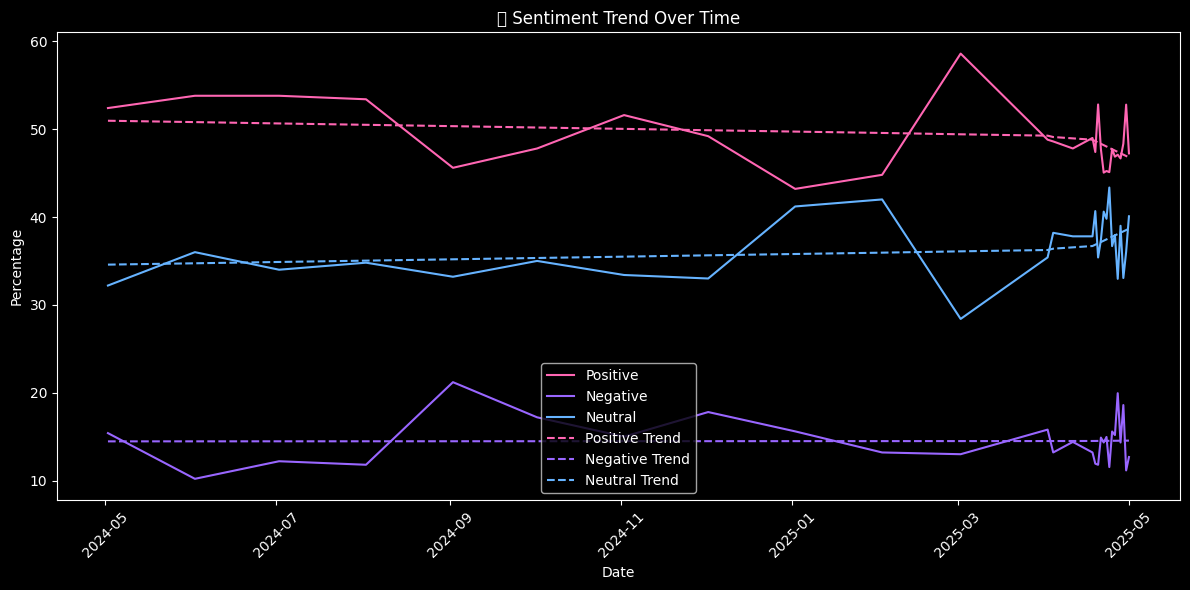

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dark theme
plt.style.use('dark_background')

# Convert date
summary['comment_date'] = pd.to_datetime(summary['comment_date'])

# Define poppy sentiment colors
sentiment_colors = {
    'positive': '#ff66b3',
    'negative': '#9966ff',
    'neutral': '#66b3ff'
}

# Plot sentiment lines
plt.figure(figsize=(12, 6))
plt.plot(summary['comment_date'], summary['positive_pct'], label='Positive', color=sentiment_colors['positive'])
plt.plot(summary['comment_date'], summary['negative_pct'], label='Negative', color=sentiment_colors['negative'])
plt.plot(summary['comment_date'], summary['neutral_pct'], label='Neutral', color=sentiment_colors['neutral'])

# Add matching trendlines
x = range(len(summary['comment_date']))

z_pos = np.polyfit(x, summary['positive_pct'], 1)
plt.plot(summary['comment_date'], np.poly1d(z_pos)(x), "--", color=sentiment_colors['positive'], label="Positive Trend")

z_neg = np.polyfit(x, summary['negative_pct'], 1)
plt.plot(summary['comment_date'], np.poly1d(z_neg)(x), "--", color=sentiment_colors['negative'], label="Negative Trend")

z_neu = np.polyfit(x, summary['neutral_pct'], 1)
plt.plot(summary['comment_date'], np.poly1d(z_neu)(x), "--", color=sentiment_colors['neutral'], label="Neutral Trend")

# Labels and styling
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('💬 Sentiment Trend Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-11-a220266a5c2f>:28: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


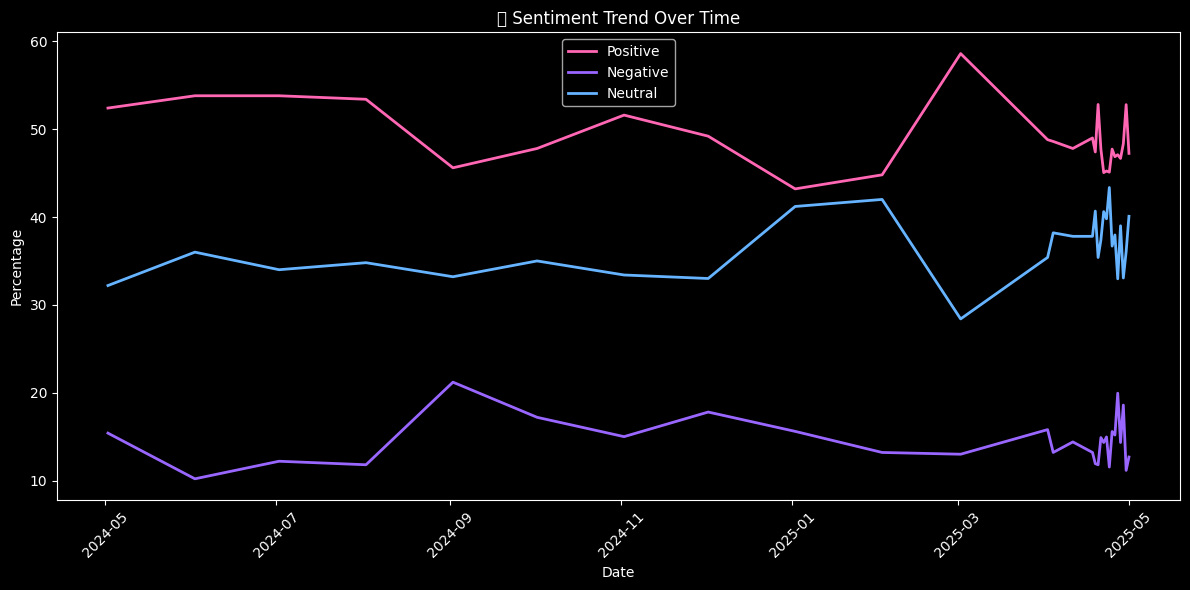

In [ ]:
import matplotlib.pyplot as plt

# Set dark background
plt.style.use('dark_background')

# Ensure date column is datetime
summary['comment_date'] = pd.to_datetime(summary['comment_date'])

# Define custom colors
sentiment_colors = {
    'positive': '#ff66b3',  # Hot pink
    'negative': '#9966ff',  # Lavender purple
    'neutral':  '#66b3ff'   # Sky blue
}

# Plot sentiment trends
plt.figure(figsize=(12, 6))
plt.plot(summary['comment_date'], summary['positive_pct'], label='Positive', color=sentiment_colors['positive'], linewidth=2)
plt.plot(summary['comment_date'], summary['negative_pct'], label='Negative', color=sentiment_colors['negative'], linewidth=2)
plt.plot(summary['comment_date'], summary['neutral_pct'], label='Neutral', color=sentiment_colors['neutral'], linewidth=2)

# Formatting
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('💬 Sentiment Trend Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
